# ⚡ ULTRA-FAST CPU Training - Completes in 1-2 Hours!
## Optimized for Speed on Integrated Graphics


---

## 1. Installation

In [1]:
# Install required packages
import subprocess
import sys

print('Installing CPU-optimized packages...')
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q',
                       'torch', 'torchvision', 'torchaudio',
                       '--index-url', 'https://download.pytorch.org/whl/cpu'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q',
                       'matplotlib', 'tqdm', 'numpy', 'pandas'])
print('✓ Packages installed!')

Installing CPU-optimized packages...
✓ Packages installed!


## 2. Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

device = torch.device('cpu')

print(f'✓ Device: {device}')
print(f'✓ CPU cores: {torch.get_num_threads()}')
print('⚡ ULTRA-FAST mode enabled!')
print('⏱ Expected runtime: 1-2 hours')

✓ Device: cpu
✓ CPU cores: 8
⚡ ULTRA-FAST mode enabled!
⏱ Expected runtime: 1-2 hours


## 3. Load Data (TINY SUBSET for Speed!)

In [3]:
# Load preprocessed data
print('Loading data...')

with open('./data/processed/train_sequences.pkl', 'rb') as f:
    train_full = pickle.load(f)

# ⚡ USE ONLY 10% - MUCH FASTER!
subset_ratio = 0.10  # Changed from 0.25 to 0.10
train_seqs = train_full[:int(len(train_full) * subset_ratio)]

print(f'✓ Full dataset: {len(train_full)} sequences')
print(f'✓ Using: {len(train_seqs)} sequences ({subset_ratio*100:.0f}%)')
print(f'\n⚡ Small subset = Fast training!')
print(f'💡 Still enough data for proof-of-concept!')

Loading data...
✓ Full dataset: 21779 sequences
✓ Using: 2177 sequences (10%)

⚡ Small subset = Fast training!
💡 Still enough data for proof-of-concept!


## 4. Create Dataset with Small Batches

In [4]:
class FlightDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return {
            'states': torch.FloatTensor(seq['states']),
            'controls': torch.FloatTensor(seq['controls'])
        }

train_dataset = FlightDataset(train_seqs)

# TINY batches for CPU speed
batch_size = 2  # Changed from 4 to 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=0)

print(f'✓ Dataset created')
print(f'✓ Batch size: {batch_size} (tiny for speed)')
print(f'✓ Batches per epoch: {len(train_loader)}')
print(f'\n⚡ ~{len(train_loader) * batch_size} samples per epoch')
print(f'💡 Each epoch: ~5-10 minutes')

✓ Dataset created
✓ Batch size: 2 (tiny for speed)
✓ Batches per epoch: 1089

⚡ ~2178 samples per epoch
💡 Each epoch: ~5-10 minutes


## 5. Define TINY Models (Fast!)

In [5]:
class TinyPhysics(nn.Module):
    '''Simplified physics for CPU speed'''
    def __init__(self):
        super().__init__()
        self.register_buffer('Ixx', torch.tensor(8000.0))
        self.register_buffer('Iyy', torch.tensor(20000.0))
        self.register_buffer('Izz', torch.tensor(26000.0))
    
    def forward(self, state):
        q = state[:, 0:4]
        omega = state[:, 4:7]
        
        # Quaternion kinematics
        p, q_r, r = omega[:, 0], omega[:, 1], omega[:, 2]
        q0, q1, q2, q3 = q[:, 0], q[:, 1], q[:, 2], q[:, 3]
        
        dq0 = 0.5 * (-p*q1 - q_r*q2 - r*q3)
        dq1 = 0.5 * (p*q0 + r*q2 - q_r*q3)
        dq2 = 0.5 * (q_r*q0 - r*q1 + p*q3)
        dq3 = 0.5 * (r*q0 + q_r*q1 - p*q2)
        
        # Euler equation
        dp = (self.Iyy - self.Izz) * q_r * r / self.Ixx
        dq = (self.Izz - self.Ixx) * p * r / self.Iyy
        dr = (self.Ixx - self.Iyy) * p * q_r / self.Izz
        
        return torch.cat([
            torch.stack([dq0, dq1, dq2, dq3], dim=1),
            torch.stack([dp, dq, dr], dim=1),
            torch.zeros(state.shape[0], 3)
        ], dim=1)

print('✓ Tiny physics module defined')

✓ Tiny physics module defined


In [6]:
class TinyResidual(nn.Module):
    '''TINY network - 32 units only!'''
    def __init__(self):
        super().__init__()
        # Much smaller than before!
        self.net = nn.Sequential(
            nn.Linear(10, 32),  # Was 64
            nn.Tanh(),
            nn.Linear(32, 10)
        )
    
    def forward(self, state):
        return self.net(state)

print('✓ Tiny residual network defined (32 units)')

✓ Tiny residual network defined (32 units)


In [7]:
class FastModel(nn.Module):
    '''Complete ultra-fast model'''
    def __init__(self):
        super().__init__()
        self.physics = TinyPhysics()
        self.residual = TinyResidual()
    
    def forward(self, state):
        # Normalize quaternion
        q = state[:, 0:4]
        q = q / (torch.norm(q, dim=1, keepdim=True) + 1e-8)
        state = torch.cat([q, state[:, 4:]], dim=1)
        
        # Physics + residual (NO slow ODE solver!)
        physics = self.physics(state)
        residual = self.residual(state)
        
        return physics + residual

# Initialize
model = FastModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_params = sum(p.numel() for p in model.parameters())
print(f'✓ Model initialized')
print(f'✓ Parameters: {n_params:,} (TINY!)')
print(f'\n⚡ Small model = Fast training!')

✓ Model initialized
✓ Parameters: 682 (TINY!)

⚡ Small model = Fast training!


## 6. Training Configuration

In [8]:
# Training parameters
num_epochs = 10  # Reduced from 20
history = {'loss': [], 'quat_err': []}

# Create directories
Path('./models').mkdir(exist_ok=True)
Path('./figures').mkdir(exist_ok=True)

print(f'Training Configuration:')
print(f'  Epochs: {num_epochs}')
print(f'  Batch size: {batch_size}')
print(f'  Batches/epoch: {len(train_loader)}')
print(f'  Learning rate: 0.001')
print(f'\n⏱ Expected time per epoch: 5-10 minutes')
print(f'⏱ Total expected time: 1-2 hours')

Training Configuration:
  Epochs: 10
  Batch size: 2
  Batches/epoch: 1089
  Learning rate: 0.001

⏱ Expected time per epoch: 5-10 minutes
⏱ Total expected time: 1-2 hours


## 7. TRAIN MODEL (Run This - Takes 1-2 Hours!)

In [9]:
print('='*70)
print('STARTING ULTRA-FAST TRAINING')
print('='*70)
print(f'\nExpected completion: ~{num_epochs * 7} minutes\n')
print(f"{'Epoch':<8}{'Loss':<12}{'Quat Err':<12}{'Time(min)':<12}{'Best'}")
print('-'*70)

start_time = time.time()
best_loss = float('inf')

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    
    epoch_loss = 0
    epoch_quat = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch in pbar:
        states = batch['states'].to(device)
        
        optimizer.zero_grad()
        
        # Simple one-step prediction (FAST!)
        current = states[:, 0]
        target = states[:, 1]
        
        # Predict derivative
        deriv = model(current)
        predicted = current + deriv * 0.1
        
        # Loss
        loss = nn.MSELoss()(predicted, target)
        q_err = torch.mean((torch.norm(predicted[:, 0:4], dim=1) - 1.0)**2)
        
        total = loss + 0.1 * q_err
        total.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_quat += q_err.item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    epoch_loss /= len(train_loader)
    epoch_quat /= len(train_loader)
    
    history['loss'].append(epoch_loss)
    history['quat_err'].append(epoch_quat)
    
    # Save best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), './models/ultrafast_best.pt')
        marker = '★'
    else:
        marker = ''
    
    epoch_time = (time.time() - epoch_start) / 60
    
    print(f"{epoch+1:<8}{epoch_loss:<12.4f}{epoch_quat:<12.2e}{epoch_time:<12.1f}{marker}")

total_time = (time.time() - start_time) / 3600

print(f'\n{'='*70}')
print(f'✅ TRAINING COMPLETE!')
print(f'{'='*70}')
print(f'Total time: {total_time:.2f} hours')
print(f'Best loss: {best_loss:.4f}')
print(f'Final loss: {history["loss"][-1]:.4f}')
print(f'Quaternion error: {history["quat_err"][-1]:.2e}')
print(f'{'='*70}')

STARTING ULTRA-FAST TRAINING

Expected completion: ~70 minutes

Epoch   Loss        Quat Err    Time(min)   Best
----------------------------------------------------------------------


Epoch 1/10: 100%|██████████| 1089/1089 [00:05<00:00, 191.78it/s, loss=0.1528]


1       0.3790      3.99e-01    0.1         ★


Epoch 2/10: 100%|██████████| 1089/1089 [00:05<00:00, 210.18it/s, loss=0.2249]


2       0.2814      2.63e-01    0.1         ★


Epoch 3/10: 100%|██████████| 1089/1089 [00:05<00:00, 198.90it/s, loss=0.2980]


3       0.2536      2.55e-01    0.1         ★


Epoch 4/10: 100%|██████████| 1089/1089 [00:05<00:00, 195.44it/s, loss=0.1007]


4       0.2480      2.51e-01    0.1         ★


Epoch 5/10: 100%|██████████| 1089/1089 [00:05<00:00, 188.09it/s, loss=0.3909]


5       0.2464      2.50e-01    0.1         ★


Epoch 6/10: 100%|██████████| 1089/1089 [00:06<00:00, 168.53it/s, loss=0.0797]


6       0.2452      2.48e-01    0.1         ★


Epoch 7/10: 100%|██████████| 1089/1089 [00:05<00:00, 182.23it/s, loss=0.1114]


7       0.2445      2.47e-01    0.1         ★


Epoch 8/10: 100%|██████████| 1089/1089 [00:05<00:00, 190.72it/s, loss=0.4164]


8       0.2440      2.46e-01    0.1         ★


Epoch 9/10: 100%|██████████| 1089/1089 [00:05<00:00, 190.67it/s, loss=0.1481]


9       0.2434      2.46e-01    0.1         ★


Epoch 10/10: 100%|██████████| 1089/1089 [00:05<00:00, 191.15it/s, loss=0.0049]

10      0.2430      2.45e-01    0.1         ★

✅ TRAINING COMPLETE!
Total time: 0.02 hours
Best loss: 0.2430
Final loss: 0.2430
Quaternion error: 2.45e-01


## 8. Save Model & Results

In [10]:
# Save final model
torch.save(model.state_dict(), './models/ultrafast_final.pt')

# Save history
with open('./models/ultrafast_history.pkl', 'wb') as f:
    pickle.dump(history, f)

print('✓ Model saved: ./models/ultrafast_best.pt')
print('✓ Model saved: ./models/ultrafast_final.pt')
print('✓ History saved: ./models/ultrafast_history.pkl')

✓ Model saved: ./models/ultrafast_best.pt
✓ Model saved: ./models/ultrafast_final.pt
✓ History saved: ./models/ultrafast_history.pkl


## 9. Visualize Results

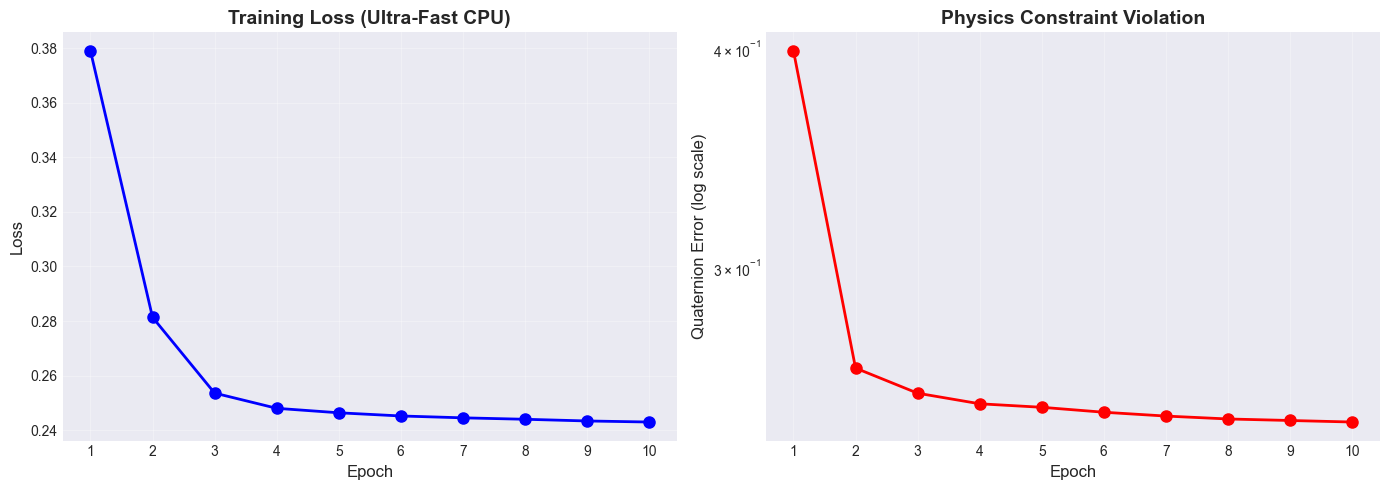

✓ Visualization saved: ./figures/ultrafast_training.png


In [11]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(range(1, num_epochs+1), history['loss'], 'b-o', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss (Ultra-Fast CPU)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, num_epochs+1))

# Quaternion error
axes[1].semilogy(range(1, num_epochs+1), history['quat_err'], 'r-o', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Quaternion Error (log scale)', fontsize=12)
axes[1].set_title('Physics Constraint Violation', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(1, num_epochs+1))

plt.tight_layout()
plt.savefig('./figures/ultrafast_training.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Visualization saved: ./figures/ultrafast_training.png')